In [38]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns

from scipy.interpolate import make_interp_spline
from scipy.stats import pearsonr
from scipy.stats import spearmanr

%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
%matplotlib inline

# Global trends from paleo-physiography dataset

### Dataset link

Salles, T., L. Husson, M. Lorcery, B. Halder Boggiani (2022). Paleo-Physiography Elevation-only Dataset, HydroShare, http://www.hydroshare.org/resource/b3f1e3581d174bf58b00ba5672604710

### THREDDS Data Service

https://thredds.hydroshare.org/thredds/catalog/hydroshare/resources/b3f1e3581d174bf58b00ba5672604710/data/contents/catalog.html

For this notebook, the dataset on Hydroshare has been downloaded locally.

In [ ]:
hydroshare = 'outputs/nphysio/physio'

Load the simulation times:

In [3]:
bristol_model = pd.read_csv('dataset/bristol_sim_list.csv')
bristol_model

,model,time,name
0,texqe,541,541Ma
1,texqd,535,535Ma
2,texqc,530,530Ma
3,texqb,525,525Ma
4,texqa,520,520Ma
...,...,...,...
104,texpe,20,20Ma
105,texpd,15,15Ma
106,texpc,11,11Ma
107,texpb,3,3Ma


## Cells area calculation

Cell areas calculation:

$$dA = a^2 cos(\theta) (1-e^2) d\theta dl / (1-e^2 sin^2\theta)^2$$
where:

- Latitude ($\theta$) = latitude of cell's center (in radians)
- Unit of Latitude (d$\theta$) = 0.05$^o$ 
- Unit of Longitude (dl) = 0.05$^o$ 

The WGS84 spheroid is used for values of Earth's radius and eccentricity:

- Equatorial radius (a) = 6378.137 km
- Eccentricity (e) = 0.08181919


In [6]:
def getCellArea(ds):

    res = 0.05
    dlat = res*np.pi/180.
    dlon = res*np.pi/180.
    a = 6378.137
    e = 0.08181919

    lat = ds.latitude.data
    lon = ds.longitude.data

    mlon, mlat = np.meshgrid(lon, lat)
    mlonlat = np.dstack([mlon.flatten(), mlat.flatten()])[0]

    rlat = mlat.flatten()*np.pi/180.
    cellArea = a**2 * np.cos(rlat) * (1. - e**2) * dlat * dlon / (1. - e**2 * np.sin(rlat)**2)**2
    
    return cellArea

cellArea = getCellArea(xr.open_dataset(hydroshare+'0Ma.nc'))

# Extract global trends

Then we loop over all time steps and extract some of the simulation parameters:

+ the continental surface area percentage `contPerc`
+ the continental mean and max elevation `meanElev` & `maxElev`
+ the continental mean precipitation from Valdes et al. (2021) `meanRain`
+ the average erosion/deposition rate `meanEro`and the total sediment flux (erosion `sumEro`, deposition `sumDepo`) 
+ the average physio-diversity index (`meanDiv`)

In [9]:
def getTrends(ncfilename, area):
    
    ds = xr.open_dataset(hydroshare+str(time)+'Ma.nc')
    
    factor = np.where(ds.z>0,1,0).flatten()
    elev = ds.z.data
    rain = ds.rain.data
    erate = ds.erorate.data
    div = ds.phydiv.data
    
    # Set nan values below sealevel
    elev[elev<0] = np.nan
    rain[elev<0] = np.nan
    erate[elev<0] = np.nan
    div[elev<0] = np.nan
     
    perc = (area*factor).sum()/area.sum()
    maxelev = np.nanmax(elev)
    meanelev = np.nanmean(elev)
    
    meanrain = np.nanmean(rain)
    meanero = np.nanmean(erate)
    meandiv = np.nanmean(div)
    
    flux = erate.flatten()*area*1.e-6
    flux = flux[~np.isnan(flux)]
    depids = np.where(flux>0)
    eroids = np.where(flux<0)
    fluxsed = np.nansum(flux[depids])
    fluxero = -np.nansum(flux[eroids])
    
    ds.close()
    
    return perc, maxelev, meanelev, meanrain, meanero, meandiv, fluxsed, fluxero

In [10]:
contPerc = []
maxElev = []
meanElev = []
meanRain = []
meanEro = []
meanDiv = []
sumEro = []
sumDepo = []

for t in range(len(bristol_model)-1,-1,-1):
    
    time = bristol_model.time.iloc[t]
    
    trend = getTrends(hydroshare+str(time)+'Ma.nc', cellArea)
    
    contPerc.append(trend[0])
    maxElev.append(trend[1])
    meanElev.append(trend[2])
    meanRain.append(trend[3])
    meanEro.append(trend[4])
    meanDiv.append(trend[5])
    sumDepo.append(trend[6])
    sumEro.append(trend[7])

Save these global trends in a `csv` file:

In [60]:
data = {
        "contPerc": contPerc,
        "maxElev": maxElev,
        "meanElev": meanElev,
        "meanRain": meanRain,
        "meanEro": -np.asarray(meanEro),
        "meanDiv": meanDiv,
        "sumEro": sumEro,
        "sumDepo": sumDepo,
        }
df = pd.DataFrame(data)
df.to_csv("globalTrends.csv", index=False)

# Temporal plots

Let's load the global trends dataset:

In [61]:
time = -np.flipud(bristol_model.time.values)
trend_df = pd.read_csv('globalTrends.csv')
trend_df

,contPerc,maxElev,meanElev,meanRain,meanEro,meanDiv,sumEro,sumDepo
0,0.286694,7463.419660,637.136900,0.869217,0.024307,0.689654,4.774535,0.400759
1,0.296173,7613.353506,606.358057,0.891394,0.020376,0.695478,4.215931,0.380780
2,0.308887,8357.117872,600.436843,0.878049,0.020104,0.685280,4.509728,0.564478
3,0.311242,9767.796960,634.245648,0.877668,0.017989,0.689736,4.042337,0.398467
4,0.309769,11955.446048,711.876921,0.893673,0.020938,0.689756,4.753572,0.528873
...,...,...,...,...,...,...,...,...
104,0.157940,2495.082797,364.258005,1.026162,0.010951,0.633581,1.088520,0.065925
105,0.164597,2728.051194,378.233330,1.012060,0.010557,0.645083,1.111315,0.063901
106,0.173487,3315.924307,393.883549,1.007217,0.010461,0.647240,1.188853,0.070657
107,0.181557,3846.716930,413.466568,0.992019,0.010557,0.638642,1.254611,0.084385


Pairwise relationships:

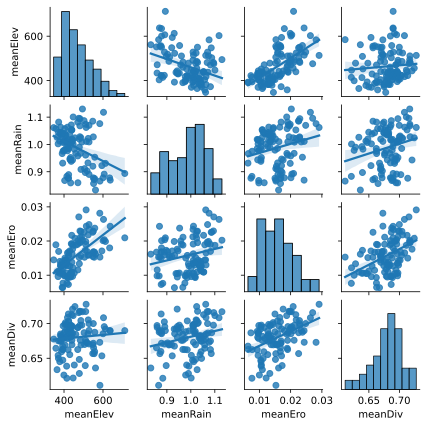

In [120]:
sns.pairplot(trend_df[['meanElev','meanRain','meanEro','meanDiv']], kind="reg", size=1.5)
plt.show()

We will now make several plot to evaluate these parameters. 

In [86]:
def getCorrelations(data1, data2):
    
    cpearson, _ = pearsonr(np.asarray(data1), np.asarray(data2))
    cspearman, _ = spearmanr(np.asarray(data1), np.asarray(data2))

    print('Pearsons correlation value: %.3f' % cpearson)
    print('Spearman correlation value: %.3f' % cspearman)

    return cpearson, cspearman

def smoothCurve(time, data, nbfine=542, nbcoarse=50):
    
    ftime = np.linspace(time.min(), time.max(), nbfine)
    ctime = np.linspace(time.min(), time.max(), nbcoarse)
    
    interp = make_interp_spline(time, np.asarray(data), k=3)
    
    return [-ftime,interp(ftime)],[-ctime,interp(ctime)]

### Surface and continental area

Trend in surface elevation and continental area percentage:

In [105]:
fineElev, coarseElev = smoothCurve(-time, trend_df['meanElev'])
finecPerc, coarsecPerc = smoothCurve(-time, trend_df['contPerc'])

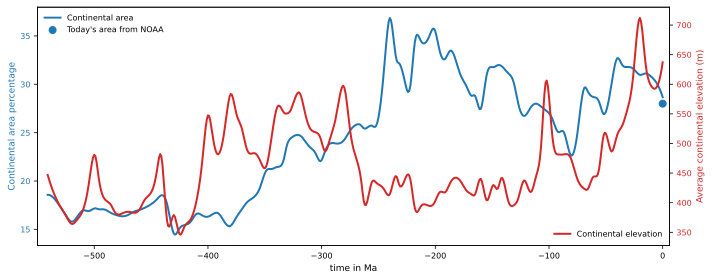

In [111]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)

ax1.plot(finecPerc[0], finecPerc[1]*100, '-', color='tab:blue', zorder=2, lw=2, 
         label='Continental area')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylabel('Continental area percentage', 
               color='tab:blue', fontsize=9)
# NOAA data
ax1.scatter(0, (1-0.72)*100, marker='o', c='tab:blue', edgecolors='tab:blue', s=50, 
            label="Today's area from NOAA")
plt.legend(frameon=False, prop={'size': 8}, loc=2)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel('time in Ma', fontsize=9)
plt.xlim([-550,6])

ax2 = ax1.twinx()
ax2.set_ylabel('Average continental elevation (m)', color='tab:red', fontsize=9)
ax2.plot(fineElev[0], fineElev[1], color='tab:red', lw=2, label='Continental elevation')
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(frameon=False, prop={'size': 8}, loc=4)

fig.tight_layout()
# plt.savefig('trend_surface.pdf')
plt.show()

### Erosion rates evaluation

We will be using the following measurements for present-day:

Global geologic erosion (mm/yr)

+ Montgomery and Brandon (1) - 0.017
+ Wilkinson (2) - 0.024
+ Wilkinson and McElroy (3) - 0.016

References: 

1. DR Montgomery, MT Brandon Earth Planet Sci Lett 201, 481–489 (2002). 
2. BH Wilkinson Geology 33, 161–164 (2005).
3. BH Wilkinson, BJ McElroy Geol Soc Am Bull 119, 140–156 (2007).


We will look at the evolution of erosion rates against precipitation and elevation:

In [107]:
print('Correlation btw erosion rate and elevation:')
ero_elev_corr = getCorrelations(trend_df['meanEro'], trend_df['meanElev'])
print('\nCorrelation btw erosion rate and precipitation:')
ero_rain_corr = getCorrelations(trend_df['meanEro'], trend_df['meanRain'])

Correlation btw erosion rate and elevation:
Pearsons correlation value: 0.627
Spearman correlation value: 0.670

Correlation btw erosion rate and precipitation:
Pearsons correlation value: 0.237
Spearman correlation value: 0.223


In [108]:
fineEro, coarseEro = smoothCurve(-time, trend_df['meanEro'])
fineRain, coarseRain = smoothCurve(-time, trend_df['meanRain'])

Let's make the plots:

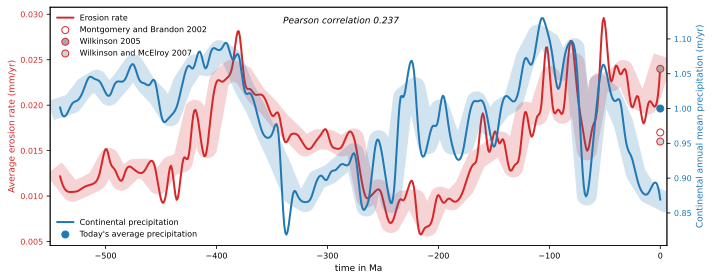

In [112]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)

ax1.plot(fineEro[0], fineEro[1], '-', color='tab:red', zorder=2, lw=2, label='Erosion rate')
ax1.plot(coarseEro[0], coarseEro[1], color='tab:red', lw=20, ls='-', zorder=1, alpha=0.2)

ax1.scatter(0, 0.017,marker='o',c='w',edgecolors='tab:red',s=50, zorder=3, label="Montgomery and Brandon 2002")
ax1.scatter(0, 0.024,marker='o',c='darkgrey',edgecolors='tab:red',s=50, zorder=3, label="Wilkinson 2005")
ax1.scatter(0, 0.016,marker='o',c='lightgray',edgecolors='tab:red',s=50, zorder=3, label="Wilkinson and McElroy 2007")

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax1.tick_params(axis='y', labelcolor='tab:red')

plt.ylabel('Average erosion rate (mm/yr)', fontsize=9, color='tab:red')
plt.legend(frameon=False, prop={'size': 8}, loc=2)

plt.xlabel('time in Ma', fontsize=9)
plt.xlim([-550,6])

ax2 = ax1.twinx()
ax2.set_ylabel('Continental annual mean precipitation (m/yr)', color='tab:blue', fontsize=9)
ax2.plot(fineRain[0], fineRain[1], color='tab:blue', lw=2, label='Continental precipitation')
ax2.plot(coarseRain[0], coarseRain[1], color='tab:blue', lw=20, ls='-', zorder=1, alpha=0.2)
ax2.scatter(0, 1.,marker='o',c='tab:blue',edgecolors='tab:blue',s=50, label="Today's average precipitation")
ax2.tick_params(axis='y', labelcolor='tab:blue')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

ax1.text(-340, 0.029, 'Pearson correlation %.3f'% ero_rain_corr[0], style='italic', fontsize=9)

plt.legend(frameon=False, prop={'size': 8}, loc=3)

fig.tight_layout()
# plt.savefig('trend_ero_rain.pdf')
plt.show()

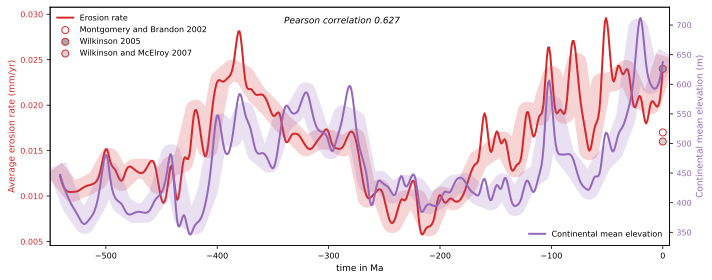

In [118]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)

ax1.plot(fineEro[0], fineEro[1], '-', color='tab:red', zorder=2, lw=2, label='Erosion rate')
ax1.plot(coarseEro[0], coarseEro[1], color='tab:red', lw=20, ls='-', zorder=1, alpha=0.2)

ax1.scatter(0, 0.017,marker='o',c='w',edgecolors='tab:red',s=50, zorder=3, label="Montgomery and Brandon 2002")
ax1.scatter(0, 0.024,marker='o',c='darkgrey',edgecolors='tab:red',s=50, zorder=3, label="Wilkinson 2005")
ax1.scatter(0, 0.016,marker='o',c='lightgray',edgecolors='tab:red',s=50, zorder=3, label="Wilkinson and McElroy 2007")

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax1.tick_params(axis='y', labelcolor='tab:red')

plt.ylabel('Average erosion rate (mm/yr)', fontsize=9, color='tab:red')
plt.legend(frameon=False, prop={'size': 8}, loc=2)

plt.xlabel('time in Ma', fontsize=9)
plt.xlim([-550,6])

ax2 = ax1.twinx()
ax2.set_ylabel('Continental mean elevation (m)', color='tab:purple', fontsize=9)
ax2.plot(fineElev[0], fineElev[1], color='tab:purple', lw=2, label='Continental mean elevation')
ax2.plot(coarseElev[0], coarseElev[1], color='tab:purple', lw=20, ls='-', zorder=1, alpha=0.2)
ax2.tick_params(axis='y', labelcolor='tab:purple')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

ax1.text(-340, 0.029, 'Pearson correlation %.3f'% ero_elev_corr[0], style='italic', fontsize=9)

plt.legend(frameon=False, prop={'size': 8}, loc=4)

fig.tight_layout()
# plt.savefig('trend_ero_elev.pdf')
plt.show()

### Sediment flux evaluation

Get sediment net flux:

In [172]:
fine_eFlx, coarse_eFlx = smoothCurve(-time, trend_df['sumEro'])
fine_sFlx, coarse_sFlx = smoothCurve(-time, trend_df['sumDepo'])

netFlx = fine_eFlx[1]-fine_sFlx[1]
netcFlx = coarse_eFlx[1]-coarse_sFlx[1]

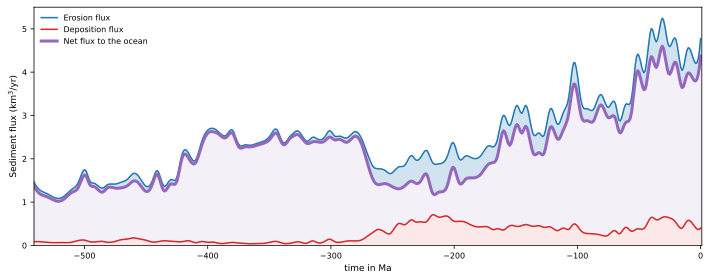

In [169]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)

ax1.plot(fine_eFlx[0], fine_eFlx[1], '-', color='tab:blue', zorder=2, lw=1.5, label='Erosion flux')
ax1.plot(fine_sFlx[0], fine_sFlx[1], '-', color='tab:red', zorder=2, lw=1.5, label='Deposition flux')
ax1.plot(fine_sFlx[0], netFlx, '-', color='tab:purple', zorder=2, lw=3, label='Net flux to the ocean')

plt.fill_between(fine_eFlx[0], -100, fine_sFlx[1], color='tab:red', alpha=0.1)
plt.fill_between(fine_eFlx[0], fine_sFlx[1], netFlx, color='tab:purple', alpha=0.1)
plt.fill_between(fine_eFlx[0], netFlx, fine_eFlx[1], color='tab:blue', alpha=0.2)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([-541,1])
plt.ylim([0,5.5])
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_ylabel('Sediment flux (km$^3$/yr)', fontsize=9, color='k')

plt.xlabel('time in Ma', fontsize=9)

plt.legend(frameon=False, prop={'size': 8}, loc=2)
fig.tight_layout()
# plt.savefig('trend_sedflux.pdf')

plt.show()

Dataset extracted from:

**Phanerozoic Earth System Evolution and Marine Biodiversity**, _B. Hannisdal and S. E. Peters_, Science 334, 1121 (2011) DOI: 10.1126/science.1210695

We load the raw time series data for marine genus diversity, geochemical records, and macrostratigraphic data. 

Genus diversity derive from the Paleobiology Database (http://paleodb.org), macrostratigraphic data derive from Macrostrat (http://macrostrat.org), timescale is adapted from the International Commission on Stratigraphy (http://www.stratigraphy.org).

In [158]:
phan_raw = pd.read_csv('dataset/phanerozoic_data_raw.csv')
# phan_sqs = pd.read_csv('dataset/phanerozoic_data_sqs.csv')
phan_raw

,age,packages,genera,genera_global,SIB_genera,Occurrences,Collections,del-18O,del-13C,87Sr-86Sr,del-34S,sea_level
0,498.900,313,192,343,170,1364,240,-7.46090,-0.094737,0.70911,32.638,58.382
1,494.650,314,141,312,121,684,170,-7.46090,-0.094737,0.70911,31.714,62.361
2,490.400,312,150,326,129,365,88,-9.55400,-1.427700,0.70910,31.067,69.591
3,483.450,326,267,615,247,914,287,-9.55400,-1.427700,0.70901,30.107,78.896
4,475.200,309,381,719,352,2287,571,-7.83880,-1.136500,0.70890,28.112,83.975
...,...,...,...,...,...,...,...,...,...,...,...,...
75,14.810,112,700,1715,218,661,120,-1.07420,2.577900,0.70878,21.974,43.455
76,12.629,114,732,1728,248,579,76,-0.81388,2.242300,0.70883,22.104,44.605
77,9.427,107,672,1669,144,520,97,-0.70298,2.417300,0.70892,22.067,45.902
78,6.289,92,670,1668,98,209,49,-0.91812,2.723500,0.70896,21.987,45.414


Get Phanerozoic dataset:

In [218]:
fineGenera, coarseGenera = smoothCurve(-phan_raw['age'].values, phan_raw['genera_global'])
fineO, coarseO = smoothCurve(-phan_raw['age'].values, phan_raw['del-18O'])
fineC, coarseC = smoothCurve(-phan_raw['age'].values, phan_raw['del-13C'])
fineSr, coarseSr = smoothCurve(-phan_raw['age'].values, phan_raw['87Sr-86Sr'])
fineS, coarseS = smoothCurve(-phan_raw['age'].values, phan_raw['del-34S'])

Smooth the dataset

In [240]:
phan_time = np.linspace(-499, -4, 496)

phan_gen_interp = make_interp_spline(-fineGenera[0], fineGenera[1], k=3)
phan_O_interp = make_interp_spline(-fineO[0], fineO[1], k=3)
phan_C_interp = make_interp_spline(-fineC[0], fineC[1], k=3)
phan_Sr_interp = make_interp_spline(-fineSr[0], fineSr[1], k=3)
phan_S_interp = make_interp_spline(-fineS[0], fineS[1], k=3)

phan_gen = phan_gen_interp(phan_time)
phan_O = phan_O_interp(phan_time)
phan_C = phan_C_interp(phan_time)
phan_Sr = phan_Sr_interp(phan_time)
phan_S = phan_S_interp(phan_time)

Compare trends from Phanerozoic dataset to net sediment flux:

In [298]:
print('Correlation btw net sediment flux and genus diversity:')
sflx_gdiv_corr = getCorrelations(np.flipud(phan_gen), netFlx[4:500])

print('\nCorrelation btw net sediment flux and del-18O:')
sflx_O_corr = getCorrelations(np.flipud(phan_O), netFlx[4:500])

print('\nCorrelation btw net sediment flux and del-13C:')
sflx_C_corr = getCorrelations(np.flipud(phan_C), netFlx[4:500])

print('\nCorrelation btw net sediment flux and 87Sr-86Sr:')
sflx_Sr_corr = getCorrelations(np.flipud(phan_Sr), netFlx[4:500])

print('\nCorrelation btw net sediment flux and del-34S:')
sflx_S_corr = getCorrelations(np.flipud(phan_S), netFlx[4:500])

Correlation btw net sediment flux and genus diversity:
Pearsons correlation value: 0.643
Spearman correlation value: 0.550

Correlation btw net sediment flux and del-18O:
Pearsons correlation value: 0.519
Spearman correlation value: 0.520

Correlation btw net sediment flux and del-13C:
Pearsons correlation value: 0.289
Spearman correlation value: 0.341

Correlation btw net sediment flux and 87Sr-86Sr:
Pearsons correlation value: -0.078
Spearman correlation value: -0.175

Correlation btw net sediment flux and del-34S:
Pearsons correlation value: -0.241
Spearman correlation value: -0.242


Compare trends from Phanerozoic dataset to net sediment flux over the last 200 Myr:

In [299]:
print('Correlation btw net sediment flux and genus diversity:')
sflx_gdiv_corr_late = getCorrelations(np.flipud(phan_gen)[:200], netFlx[4:204])

print('\nCorrelation btw net sediment flux and del-18O:')
sflx_O_corr_late = getCorrelations(np.flipud(phan_O)[:200], netFlx[4:204])

print('\nCorrelation btw net sediment flux and del-13C:')
sflx_C_corr_late = getCorrelations(np.flipud(phan_C)[:200], netFlx[4:204])

print('\nCorrelation btw net sediment flux and 87Sr-86Sr:')
sflx_Sr_corr_late = getCorrelations(np.flipud(phan_Sr)[:200], netFlx[4:204])

print('\nCorrelation btw net sediment flux and del-34S:')
sflx_S_corr_late = getCorrelations(np.flipud(phan_S)[:200], netFlx[4:204])

Correlation btw net sediment flux and genus diversity:
Pearsons correlation value: 0.891
Spearman correlation value: 0.919

Correlation btw net sediment flux and del-18O:
Pearsons correlation value: 0.011
Spearman correlation value: -0.031

Correlation btw net sediment flux and del-13C:
Pearsons correlation value: 0.435
Spearman correlation value: 0.489

Correlation btw net sediment flux and 87Sr-86Sr:
Pearsons correlation value: 0.606
Spearman correlation value: 0.641

Correlation btw net sediment flux and del-34S:
Pearsons correlation value: 0.730
Spearman correlation value: 0.641


Compare trends from Phanerozoic dataset to net sediment flux earlier than 200 Ma:

In [300]:
print('Correlation btw net sediment flux and genus diversity:')
sflx_gdiv_corr_early = getCorrelations(np.flipud(phan_gen)[196:], netFlx[200:500])

print('\nCorrelation btw net sediment flux and del-18O:')
sflx_O_corr_early = getCorrelations(np.flipud(phan_O)[196:], netFlx[200:500])

print('\nCorrelation btw net sediment flux and del-13C:')
sflx_C_corr_early = getCorrelations(np.flipud(phan_C)[196:], netFlx[200:500])

print('\nCorrelation btw net sediment flux and 87Sr-86Sr:')
sflx_Sr_corr_early = getCorrelations(np.flipud(phan_Sr)[196:], netFlx[200:500])

print('\nCorrelation btw net sediment flux and del-34S:')
sflx_S_corr_early = getCorrelations(np.flipud(phan_S)[196:], netFlx[200:500])

Correlation btw net sediment flux and genus diversity:
Pearsons correlation value: 0.410
Spearman correlation value: 0.373

Correlation btw net sediment flux and del-18O:
Pearsons correlation value: 0.255
Spearman correlation value: 0.212

Correlation btw net sediment flux and del-13C:
Pearsons correlation value: 0.418
Spearman correlation value: 0.367

Correlation btw net sediment flux and 87Sr-86Sr:
Pearsons correlation value: -0.196
Spearman correlation value: -0.172

Correlation btw net sediment flux and del-34S:
Pearsons correlation value: -0.568
Spearman correlation value: -0.519


#### Net sediment flux vs $\delta ^{18}$O

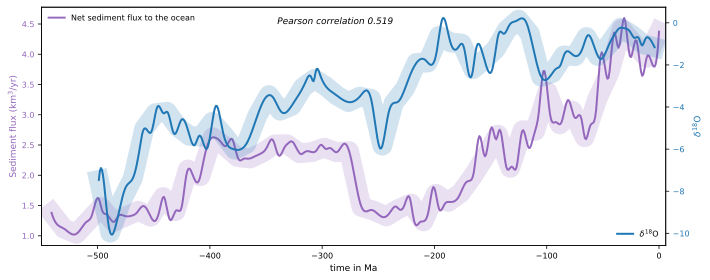

In [258]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)

ax1.plot(fine_sFlx[0], netFlx, '-', color='tab:purple', zorder=2, lw=2, label='Net sediment flux to the ocean')
ax1.plot(coarse_sFlx[0], netcFlx, color='tab:purple', lw=20, ls='-', zorder=1, alpha=0.2)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([-550,6])
ax1.tick_params(axis='y', labelcolor='tab:purple')
ax1.set_ylabel('Sediment flux (km$^3$/yr)', fontsize=9, color='tab:purple')

plt.legend(frameon=False, prop={'size': 8}, loc=2)

plt.xlabel('time in Ma', fontsize=9)

ax2 = ax1.twinx()
ax2.set_ylabel('$\delta ^{18}$O', color='tab:blue', fontsize=9)
ax2.plot(-fineO[0], fineO[1], color='tab:blue', lw=2, label='$\delta ^{18}$O')
ax2.plot(-coarseO[0], coarseO[1], color='tab:blue', lw=20, ls='-', zorder=1, alpha=0.2)
# ax2.set_ylim(210,1910)
ax2.tick_params(axis='y', labelcolor='tab:blue')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

ax1.text(-340, 4.5, 'Pearson correlation %.3f'% sflx_O_corr[0], style='italic', fontsize=9)

plt.legend(frameon=False, prop={'size': 8}, loc=4)
fig.tight_layout()
# plt.savefig('trend_flux_O18.pdf')

plt.show()

#### Net sediment flux vs genera

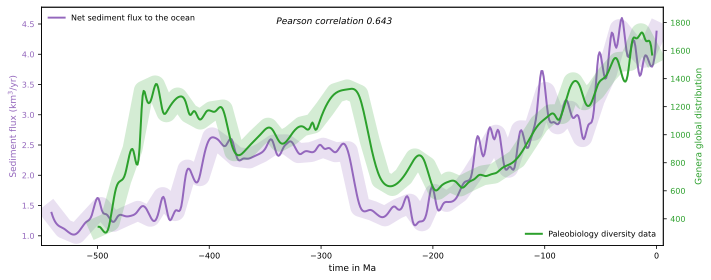

In [260]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)

ax1.plot(fine_sFlx[0], netFlx, '-', color='tab:purple', zorder=2, lw=2, label='Net sediment flux to the ocean')
ax1.plot(coarse_sFlx[0], netcFlx, color='tab:purple', lw=20, ls='-', zorder=1, alpha=0.2)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([-550,6])
ax1.tick_params(axis='y', labelcolor='tab:purple')
ax1.set_ylabel('Sediment flux (km$^3$/yr)', fontsize=9, color='tab:purple')

plt.legend(frameon=False, prop={'size': 8}, loc=2)

plt.xlabel('time in Ma', fontsize=9)

ax2 = ax1.twinx()
ax2.set_ylabel('Genera global distribution', color='tab:green', fontsize=9)
ax2.plot(-fineGenera[0], fineGenera[1], color='tab:green', lw=2, label='Paleobiology diversity data')
ax2.plot(-coarseGenera[0], coarseGenera[1], color='tab:green', lw=20, ls='-', zorder=1, alpha=0.2)
ax2.set_ylim(210,1910)
ax2.tick_params(axis='y', labelcolor='tab:green')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

ax1.text(-340, 4.5, 'Pearson correlation %.3f'% sflx_gdiv_corr[0], style='italic', fontsize=9)

plt.legend(frameon=False, prop={'size': 8}, loc=4)
fig.tight_layout()
# plt.savefig('trend_flux_bio.pdf')

plt.show()

#### Net sediment flux vs $^{87}$Sr/$^{86}$Sr 

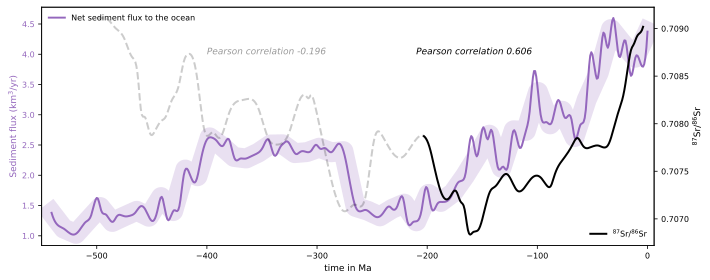

In [288]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)

ax1.plot(fine_sFlx[0], netFlx, '-', color='tab:purple', zorder=2, lw=2, label='Net sediment flux to the ocean')
ax1.plot(coarse_sFlx[0], netcFlx, color='tab:purple', lw=20, ls='-', zorder=1, alpha=0.2)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([-550,6])
ax1.tick_params(axis='y', labelcolor='tab:purple')
ax1.set_ylabel('Sediment flux (km$^3$/yr)', fontsize=9, color='tab:purple')

plt.legend(frameon=False, prop={'size': 8}, loc=2)

plt.xlabel('time in Ma', fontsize=9)

ax2 = ax1.twinx()
ax2.set_ylabel('$^{87}$Sr/$^{86}$Sr', color='k', fontsize=9)
ax2.plot(np.flipud(phan_time)[:200], np.flipud(phan_Sr)[:200], color='k', lw=2, label='$^{87}$Sr/$^{86}$Sr')
ax2.plot(np.flipud(phan_time)[196:], np.flipud(phan_Sr)[196:], color='k', lw=2, ls='--',alpha=0.2)

ax2.tick_params(axis='y', labelcolor='k')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

ax1.text(-400, 4, 'Pearson correlation %.3f'% sflx_Sr_corr_early[0], style='italic', fontsize=9, alpha=0.4)
ax1.text(-210, 4, 'Pearson correlation %.3f'% sflx_Sr_corr_late[0], style='italic', fontsize=9) #weight='bold', 

plt.legend(frameon=False, prop={'size': 8}, loc=4)
fig.tight_layout()
# plt.savefig('trend_flux_Sr_early.pdf')

plt.show()

#### Net sediment flux vs $\delta ^{34}$S

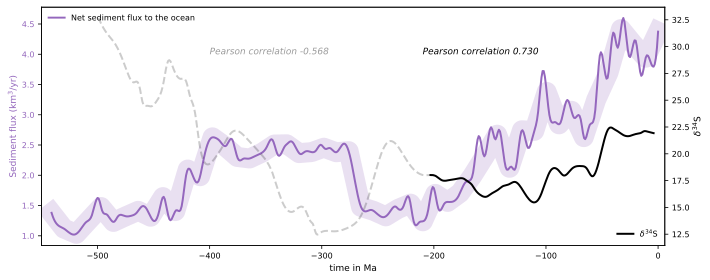

In [290]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)

ax1.plot(fine_sFlx[0], netFlx, '-', color='tab:purple', zorder=2, lw=2, label='Net sediment flux to the ocean')
ax1.plot(coarse_sFlx[0], netcFlx, color='tab:purple', lw=20, ls='-', zorder=1, alpha=0.2)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([-550,6])
ax1.tick_params(axis='y', labelcolor='tab:purple')
ax1.set_ylabel('Sediment flux (km$^3$/yr)', fontsize=9, color='tab:purple')

plt.legend(frameon=False, prop={'size': 8}, loc=2)

plt.xlabel('time in Ma', fontsize=9)

ax2 = ax1.twinx()
ax2.set_ylabel('$\delta ^{34}$S', color='k', fontsize=9)
ax2.plot(np.flipud(phan_time)[:200], np.flipud(phan_S)[:200], color='k', lw=2, label='$\delta ^{34}$S')
ax2.plot(np.flipud(phan_time)[196:], np.flipud(phan_S)[196:], color='k', lw=2, ls='--',alpha=0.2)

ax2.tick_params(axis='y', labelcolor='k')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

ax1.text(-400, 4, 'Pearson correlation %.3f'% sflx_S_corr_early[0], style='italic', fontsize=9, alpha=0.4)
ax1.text(-210, 4, 'Pearson correlation %.3f'% sflx_S_corr_late[0], style='italic', fontsize=9) #weight='bold', 

plt.legend(frameon=False, prop={'size': 8}, loc=4)
fig.tight_layout()
# plt.savefig('trend_flux_S_early.pdf')

plt.show()

#### Net sediment flux vs $\delta ^{13}$C

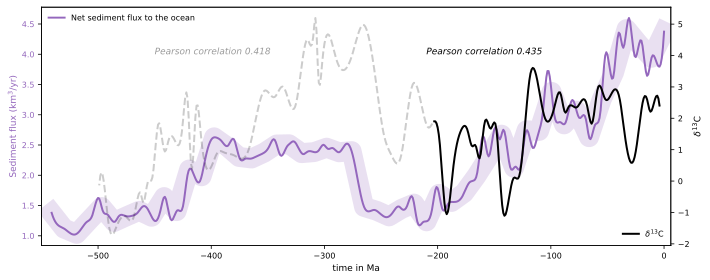

In [293]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)

ax1.plot(fine_sFlx[0], netFlx, '-', color='tab:purple', zorder=2, lw=2, label='Net sediment flux to the ocean')
ax1.plot(coarse_sFlx[0], netcFlx, color='tab:purple', lw=20, ls='-', zorder=1, alpha=0.2)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([-550,6])
ax1.tick_params(axis='y', labelcolor='tab:purple')
ax1.set_ylabel('Sediment flux (km$^3$/yr)', fontsize=9, color='tab:purple')

plt.legend(frameon=False, prop={'size': 8}, loc=2)

plt.xlabel('time in Ma', fontsize=9)

ax2 = ax1.twinx()
ax2.set_ylabel('$\delta ^{13}$C', color='k', fontsize=9)
ax2.plot(np.flipud(phan_time)[:200], np.flipud(phan_C)[:200], color='k', lw=2, label='$\delta ^{13}$C')
ax2.plot(np.flipud(phan_time)[196:], np.flipud(phan_C)[196:], color='k', lw=2, ls='--',alpha=0.2)

ax2.tick_params(axis='y', labelcolor='k')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

ax1.text(-450, 4, 'Pearson correlation %.3f'% sflx_C_corr_early[0], style='italic', fontsize=9, alpha=0.4)
ax1.text(-210, 4, 'Pearson correlation %.3f'% sflx_C_corr_late[0], style='italic', fontsize=9) #weight='bold', 

plt.legend(frameon=False, prop={'size': 8}, loc=4)
fig.tight_layout()
# plt.savefig('trend_flux_C_early.pdf')

plt.show()

### Paleo-physiography diversity evaluation

In [215]:
fine_pDiv, coarse_pDiv = smoothCurve(-time, trend_df['meanDiv'])

In [302]:
print('Correlation btw physio. div. and genus diversity:')
div_gdiv_corr = getCorrelations(np.flipud(phan_gen), fine_pDiv[1][4:500])

print('\nCorrelation btw physio. div. and del-18O:')
div_O_corr = getCorrelations(np.flipud(phan_O), fine_pDiv[1][4:500])

print('\nCorrelation btw physio. div. and del-13C:')
div_C_corr = getCorrelations(np.flipud(phan_C), fine_pDiv[1][4:500])

print('\nCorrelation btw physio. div. and 87Sr-86Sr:')
div_Sr_corr = getCorrelations(np.flipud(phan_Sr), fine_pDiv[1][4:500])

print('\nCorrelation btw physio. div. and del-34S:')
div_S_corr = getCorrelations(np.flipud(phan_S), fine_pDiv[1][4:500])

Correlation btw physio. div. and genus diversity:
Pearsons correlation value: 0.122
Spearman correlation value: 0.103

Correlation btw physio. div. and del-18O:
Pearsons correlation value: 0.305
Spearman correlation value: 0.400

Correlation btw physio. div. and del-13C:
Pearsons correlation value: -0.032
Spearman correlation value: -0.007

Correlation btw physio. div. and 87Sr-86Sr:
Pearsons correlation value: -0.279
Spearman correlation value: -0.392

Correlation btw physio. div. and del-34S:
Pearsons correlation value: -0.081
Spearman correlation value: -0.076


In [303]:
print('Correlation btw physio. div. and genus diversity:')
div_gdiv_corr_late = getCorrelations(np.flipud(phan_gen)[:200], fine_pDiv[1][4:204])

print('\nCorrelation btw physio. div. and del-18O:')
div_O_corr_late = getCorrelations(np.flipud(phan_O)[:200], fine_pDiv[1][4:204])

print('\nCorrelation btw physio. div. and del-13C:')
div_C_corr_late = getCorrelations(np.flipud(phan_C)[:200], fine_pDiv[1][4:204])

print('\nCorrelation btw physio. div. and 87Sr-86Sr:')
div_Sr_corr_late = getCorrelations(np.flipud(phan_Sr)[:200], fine_pDiv[1][4:204])

print('\nCorrelation btw physio. div. and del-34S:')
div_S_corr_late = getCorrelations(np.flipud(phan_S)[:200], fine_pDiv[1][4:204])

Correlation btw physio. div. and genus diversity:
Pearsons correlation value: 0.252
Spearman correlation value: 0.203

Correlation btw physio. div. and del-18O:
Pearsons correlation value: -0.253
Spearman correlation value: -0.374

Correlation btw physio. div. and del-13C:
Pearsons correlation value: 0.334
Spearman correlation value: 0.401

Correlation btw physio. div. and 87Sr-86Sr:
Pearsons correlation value: -0.125
Spearman correlation value: -0.039

Correlation btw physio. div. and del-34S:
Pearsons correlation value: -0.137
Spearman correlation value: -0.091


In [304]:
print('Correlation btw physio. div. and genus diversity:')
div_gdiv_corr_early = getCorrelations(np.flipud(phan_gen)[196:], fine_pDiv[1][200:500])

print('\nCorrelation btw physio. div. and del-18O:')
div_O_corr_early = getCorrelations(np.flipud(phan_O)[196:], fine_pDiv[1][200:500])

print('\nCorrelation btw physio. div. and del-13C:')
div_C_corr_early = getCorrelations(np.flipud(phan_C)[196:], fine_pDiv[1][200:500])

print('\nCorrelation btw physio. div. and 87Sr-86Sr:')
div_Sr_corr_early = getCorrelations(np.flipud(phan_Sr)[196:], fine_pDiv[1][200:500])

print('\nCorrelation btw physio. div. and del-34S:')
div_S_corr_early = getCorrelations(np.flipud(phan_S)[196:], fine_pDiv[1][200:500])

Correlation btw physio. div. and genus diversity:
Pearsons correlation value: -0.052
Spearman correlation value: -0.108

Correlation btw physio. div. and del-18O:
Pearsons correlation value: -0.276
Spearman correlation value: -0.292

Correlation btw physio. div. and del-13C:
Pearsons correlation value: -0.137
Spearman correlation value: -0.149

Correlation btw physio. div. and 87Sr-86Sr:
Pearsons correlation value: -0.017
Spearman correlation value: -0.010

Correlation btw physio. div. and del-34S:
Pearsons correlation value: 0.108
Spearman correlation value: 0.154


In [305]:
trend_df

,contPerc,maxElev,meanElev,meanRain,meanEro,meanDiv,sumEro,sumDepo
0,0.286694,7463.419660,637.136900,0.869217,0.024307,0.689654,4.774535,0.400759
1,0.296173,7613.353506,606.358057,0.891394,0.020376,0.695478,4.215931,0.380780
2,0.308887,8357.117872,600.436843,0.878049,0.020104,0.685280,4.509728,0.564478
3,0.311242,9767.796960,634.245648,0.877668,0.017989,0.689736,4.042337,0.398467
4,0.309769,11955.446048,711.876921,0.893673,0.020938,0.689756,4.753572,0.528873
...,...,...,...,...,...,...,...,...
104,0.157940,2495.082797,364.258005,1.026162,0.010951,0.633581,1.088520,0.065925
105,0.164597,2728.051194,378.233330,1.012060,0.010557,0.645083,1.111315,0.063901
106,0.173487,3315.924307,393.883549,1.007217,0.010461,0.647240,1.188853,0.070657
107,0.181557,3846.716930,413.466568,0.992019,0.010557,0.638642,1.254611,0.084385


In [306]:
print('Correlation btw physio. diversity and erosion rate:')
div_ero_corr = getCorrelations(trend_df['meanDiv'], trend_df['meanEro'])

print('\nCorrelation btw physio. diversity and precipitation:')
div_rain_corr = getCorrelations(trend_df['meanDiv'], trend_df['meanRain'])

Correlation btw physio. diversity and erosion rate:
Pearsons correlation value: 0.438
Spearman correlation value: 0.432

Correlation btw physio. diversity and precipitation:
Pearsons correlation value: 0.243
Spearman correlation value: 0.214


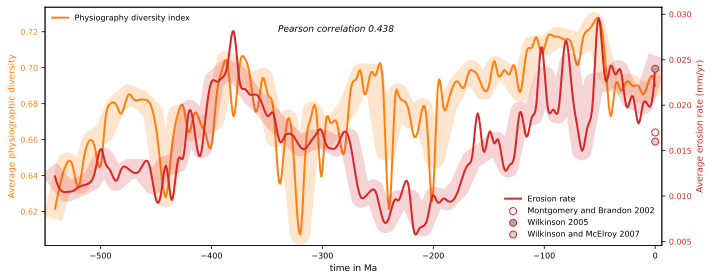

In [311]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)

ax1.plot(fine_pDiv[0], fine_pDiv[1], '-', color='tab:orange', zorder=2, lw=2, label='Physiography diversity index')
ax1.plot(coarse_pDiv[0], coarse_pDiv[1], color='tab:orange', lw=20, ls='-', zorder=1, alpha=0.2)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([-550,6])
ax1.tick_params(axis='y', labelcolor='tab:orange')
ax1.set_ylabel('Average physiographic diversity', fontsize=9, color='tab:orange')

plt.legend(frameon=False, prop={'size': 8}, loc=2)

plt.xlabel('time in Ma', fontsize=9)

ax2 = ax1.twinx()

ax2.plot(fineEro[0], fineEro[1], '-', color='tab:red', zorder=2, lw=2, label='Erosion rate')
ax2.plot(coarseEro[0], coarseEro[1], color='tab:red', lw=20, ls='-', zorder=1, alpha=0.2)

ax2.scatter(0, 0.017,marker='o',c='w',edgecolors='tab:red',s=50, zorder=3, label="Montgomery and Brandon 2002")
ax2.scatter(0, 0.024,marker='o',c='darkgrey',edgecolors='tab:red',s=50, zorder=3, label="Wilkinson 2005")
ax2.scatter(0, 0.016,marker='o',c='lightgray',edgecolors='tab:red',s=50, zorder=3, label="Wilkinson and McElroy 2007")

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax2.tick_params(axis='y', labelcolor='tab:red')

ax2.set_ylabel('Average erosion rate (mm/yr)', fontsize=9, color='tab:red')
plt.legend(frameon=False, prop={'size': 8}, loc=2)



ax1.text(-340, 0.72, 'Pearson correlation %.3f'% div_ero_corr[0], style='italic', fontsize=9)

plt.legend(frameon=False, prop={'size': 8}, loc=3)

plt.legend(frameon=False, prop={'size': 8}, loc=4)
fig.tight_layout()
# plt.savefig('trend_pdiv_ero.pdf')

plt.show()

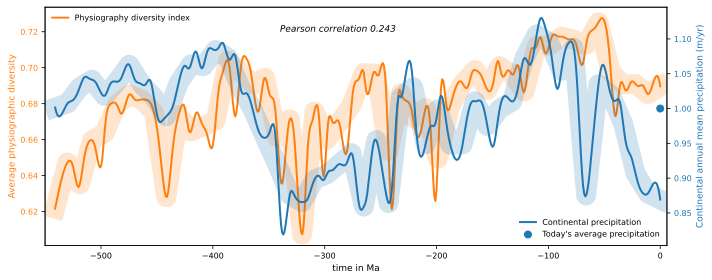

In [309]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)

ax1.plot(fine_pDiv[0], fine_pDiv[1], '-', color='tab:orange', zorder=2, lw=2, label='Physiography diversity index')
ax1.plot(coarse_pDiv[0], coarse_pDiv[1], color='tab:orange', lw=20, ls='-', zorder=1, alpha=0.2)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([-550,6])
ax1.tick_params(axis='y', labelcolor='tab:orange')
ax1.set_ylabel('Average physiographic diversity', fontsize=9, color='tab:orange')

plt.legend(frameon=False, prop={'size': 8}, loc=2)

plt.xlabel('time in Ma', fontsize=9)

ax2 = ax1.twinx()
ax2.set_ylabel('Continental annual mean precipitation (m/yr)', color='tab:blue', fontsize=9)
ax2.plot(fineRain[0], fineRain[1], color='tab:blue', lw=2, label='Continental precipitation')
ax2.plot(coarseRain[0], coarseRain[1], color='tab:blue', lw=20, ls='-', zorder=1, alpha=0.2)
ax2.scatter(0, 1.,marker='o',c='tab:blue',edgecolors='tab:blue',s=50, label="Today's average precipitation")
ax2.tick_params(axis='y', labelcolor='tab:blue')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

ax1.text(-340, 0.72, 'Pearson correlation %.3f'% div_rain_corr[0], style='italic', fontsize=9)

plt.legend(frameon=False, prop={'size': 8}, loc=3)

plt.legend(frameon=False, prop={'size': 8}, loc=4)
fig.tight_layout()
# plt.savefig('trend_pdiv_rain.pdf')

plt.show()

# Hypsometric curve

The histogram is determined using the equation above used to calculate the area of each cell, and then we group them by elevation and sum them.

In [312]:
def func(x):
    y = np.sum(x)
    return y

time = 0
nbins = 800
bins = np.flip(np.linspace(-5000, 5000, nbins))

zdata = xr.open_dataset(hydroshare+str(time)+'Ma.nc') #, chunks={'latitude': 500, 'longitude': 500})

elevsim = zdata.zsim.values.flatten()
ind1 = np.digitize(elevsim, bins)
result0 = [func(cellArea[ind1 == j]) for j in range(1, nbins)]
cumRes0 = np.cumsum(result0)
cumRes0 /= cumRes0[-1]

elev = zdata.z.values.flatten()
ind1 = np.digitize(elev, bins)
result1 = [func(cellArea[ind1 == j]) for j in range(1, nbins)]
cumRes1 = np.cumsum(result1)
cumRes1 /= cumRes1[-1]

elevpaleo = zdata.zpaleo.values.flatten()
ind1 = np.digitize(elevpaleo, bins)
result2 = [func(cellArea[ind1 == j]) for j in range(1, nbins)]
cumRes2 = np.cumsum(result2)
cumRes2 /= cumRes2[-1]

We can now plot the curve:

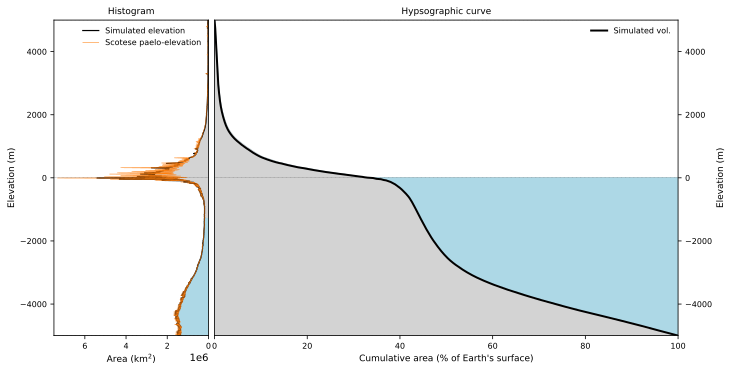

In [313]:
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]}, figsize=(10, 5), dpi=300)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Virtual Earth
a0.plot(result0, bins[1:], '-', color='k', zorder=2, lw=1.2, label='Simulated elevation')
# a0.plot(result1, bins[1:], '-', color='tab:green', zorder=2, lw=0.75, label='Adjusted elevation')
a0.plot(result2, bins[1:], '-', color='tab:orange', zorder=2, lw=0.5, label='Scotese paelo-elevation')
a0.fill_betweenx(bins[500:], 0, result0[499:], color='lightblue')
a0.fill_betweenx(bins[1:501], 0, result0[:500], color='lightgrey')
a0.plot([0,7.5e6],[-5000,-5000], ls='--',c='k',lw=0.25)
a0.plot([0,7.5e6],[0,0], ls='--',c='k',lw=0.25)
a0.plot([0,7.5e6],[5000,5000], ls='--',c='k',lw=0.25)
a0.set_ylabel('Elevation (m)', fontsize=9)
a0.set_xlabel('Area (km$^2$)', fontsize=9)
a0.set_title('Histogram', fontsize=9)
a0.set_xlim([0,7.5e6])
a0.set_ylim([-5000,5000])
a0.legend(frameon=False, prop={'size': 8}, loc=1)
a0.tick_params(axis='both', labelsize=8)
a0.invert_xaxis()

a1.plot(cumRes0*100., bins[1:], '-', color='k', zorder=2, lw=2, label='Simulated vol.')
a1.legend(frameon=False, prop={'size': 8}, loc=1)
a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
a1.set_ylabel('Elevation (m)', fontsize=9)
a1.set_xlabel("Cumulative area (% of Earth's surface)", fontsize=9)
a1.set_title('Hypsographic curve', fontsize=9)
a1.set_xlim([0,100])
a1.set_ylim([-5000,5000])
a1.plot([0,2.5e6],[-5000,-5000], ls='--', c='k',lw=0.25)
a1.plot([0,2.5e6],[0,0], ls='--', c='k',lw=0.25)
a1.plot([0,2.5e6],[5000,5000],ls='--', c='k',lw=0.25)
a1.legend(frameon=False, prop={'size': 8}, loc=1)
a1.tick_params(axis='both', labelsize=8)
a1.fill_between(cumRes2*100., bins[1:], 0, color='lightblue')
a1.fill_between(cumRes2*100.,-10000, bins[1:], color='lightgrey')
f.tight_layout(pad=0.1)
plt.savefig('hypsometry.pdf')
plt.show()